# Response Clustering

1. [Mooc tags dataset](#1)  
   1.1 [Word2Vec](#1.1)  
   1.2 [Fasttext](#1.2)  
   1.3 [Visualization](#1.3)   
2. [Reflection questions dataset](#2)  
   2.1 [Processing data](#2.1)   
   2.2 [Perform LDA and NMF](#2.2)  
   2.3 [Fasttext + Ontology + LDA](#2.3)  
   2.4 [Latent Semantic Analysis](#2.4)  
3. [Hypothesis dataset](#3)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import time
import requests
import csv
import json
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import OrderedDict

In [70]:
from conceptnet import *
from helpers import *
from lsa import *
from ontology import *
from responses_processing import *
from tags_processing import *
from topic_modelling import *
from visualization import *

In [ ]:
warnings.filterwarnings('ignore')

In [3]:
def set_size(SIZE=20):
    """
     This method sets size for labels, legends... of matplotlib.pyplot
    """

    plt.rc('font', size=SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SIZE)

In [4]:
SEED = 9016891

# 1) Mooc tags dataset
<a id='1'></a>


In [5]:
mooc_tags = pd.read_csv("data/mooc_tags.txt" ,delimiter="\t")
mooc_tags.columns = ['text']
mooc_tags.head(10)

text
0                        area
1               living things
2  plants: growth and changes
3  animals: growth and change
4                  structures
5      american music history
6                        soil
7                          pe
8                    anathomy
9              best practices

In [6]:
mooc_tags.describe()

text
count    2096
unique   2094
top     tesol
freq        2

There are 2096 tags in the database

First, depend on the dataset and on the purpose, we decide what to be removed.
Need to see some samples in the dataset and try to detect some special things to be removed.
For instant, we remove urls, hashtag, @, numbers, punctuations.

In [7]:
mooc_tags = standardize_tags(mooc_tags, "text")
mooc_tags.head(10)

text           standardized_text
0                        area                        area
1               living things               living things
2  plants: growth and changes  plants  growth and changes
3  animals: growth and change  animals  growth and change
4                  structures                  structures
5      american music history      american music history
6                        soil                        soil
7                          pe                          pe
8                    anathomy                    anathomy
9              best practices              best practices

Secondly, we need to choose `indexing terms` for our TFIDF matrix. Step by step:
* Tokenization: splitting the text into words (actually a NLP issue, think about `credit card`...)
* Stopwords removing: term explicitely to be excluded from indexing (the, a, be, this, to, or...). What happened if we have a text `to be or not to be` ?
* Lemmatization: process of reducing words. For instant: eats, eating, ate, eaten => eat. It helps reduces index size / increases information value of each indexing term.

In [8]:
mooc_tags = processing_tags(mooc_tags, 'standardized_text')
mooc_tags.head(10)

text           standardized_text  \
0                        area                        area   
1               living things               living things   
2  plants: growth and changes  plants  growth and changes   
3  animals: growth and change  animals  growth and change   
4                  structures                  structures   
5      american music history      american music history   
6                        soil                        soil   
7                          pe                          pe   
8                    anathomy                    anathomy   
9              best practices              best practices   

           processed_text  
0                    area  
1              live thing  
2     plant growth change  
3    animal growth change  
4               structure  
5  american music history  
6                    soil  
7                      pe  
8                anathomy  
9           best practice

In [9]:
mooc_tags['length'] = mooc_tags['processed_text'].apply(lambda row : len(row.split()))
mooc_tags.head(10)

text           standardized_text  \
0                        area                        area   
1               living things               living things   
2  plants: growth and changes  plants  growth and changes   
3  animals: growth and change  animals  growth and change   
4                  structures                  structures   
5      american music history      american music history   
6                        soil                        soil   
7                          pe                          pe   
8                    anathomy                    anathomy   
9              best practices              best practices   

           processed_text  length  
0                    area       1  
1              live thing       2  
2     plant growth change       3  
3    animal growth change       3  
4               structure       1  
5  american music history       3  
6                    soil       1  
7                      pe       1  
8                anathomy       1  
9           best practice       2

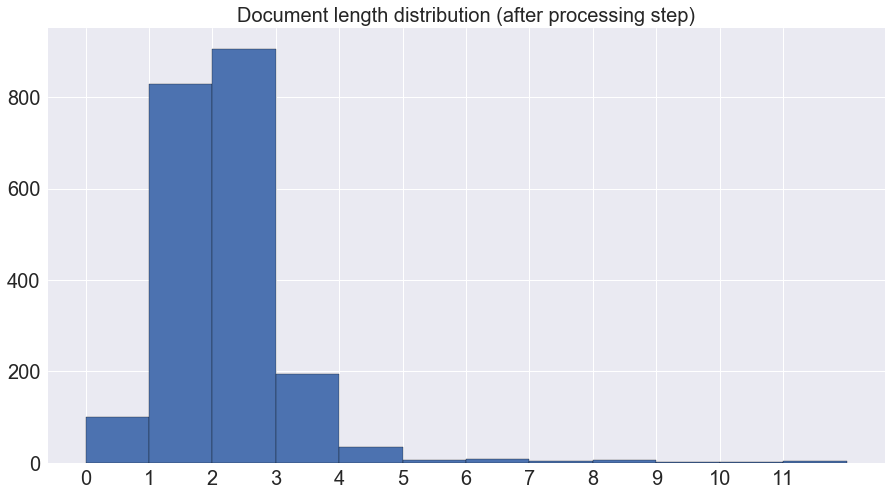

In [10]:
set_size()
plot_distribution(plt, 
                  mooc_tags['length'], 
                  'Document length distribution (after processing step)'
                 )

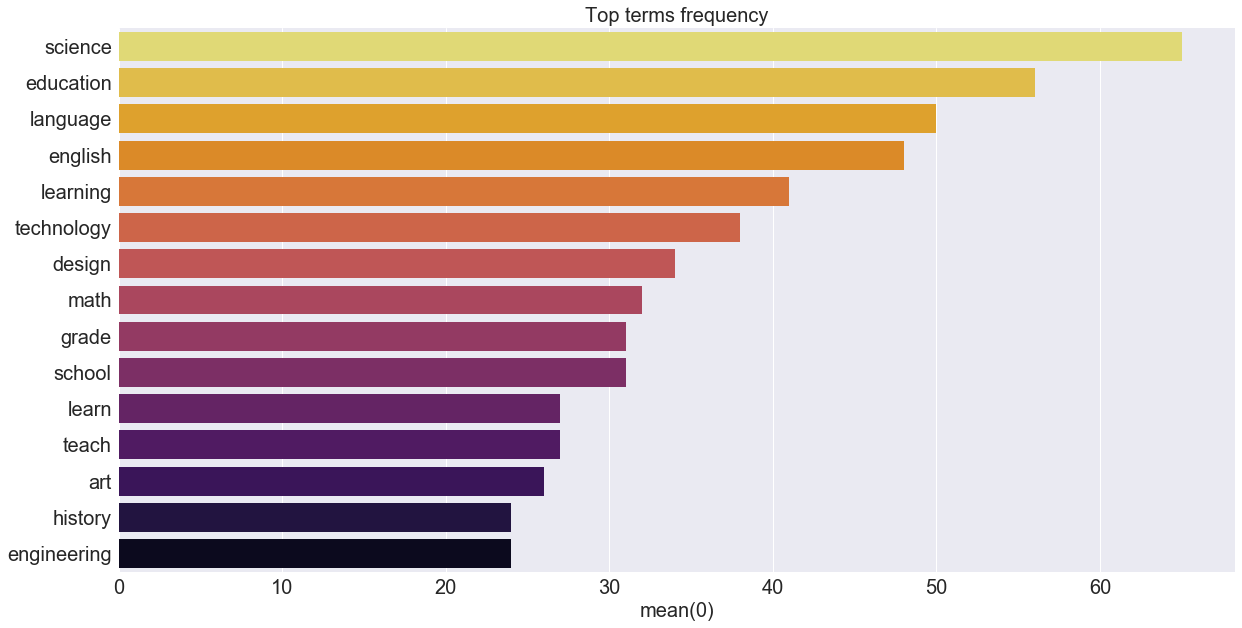

In [11]:
set_size()
plot_frequency(mooc_tags['processed_text'], title = 'Top terms frequency', plt=plt)

In [12]:
"Load pre-train model"

now = time.time()
"""
    Download word2vec pre-trained model at : "https://code.google.com/archive/p/word2vec/"
"""

word2vec_path = "/Users/Cescnghia/Documents/dataset/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

"Download pre-trained model at https://fasttext.cc/docs/en/crawl-vectors.html"

fasttext = gensim.models.KeyedVectors.load_word2vec_format("/Users/Cescnghia/Documents/dataset/wiki.en/wiki.en.vec")

print('It took {s} mins to load 2 pretrained models'.format(s=(time.time()-now)/60))

It took 12.65771726767222 mins to load 2 pretrained models


## 1.1) Word2Vec 
<a id='1.1'></a>

### 1.1.1) Word2Vec using a pre-train model of Google

In [13]:
word2vec['king'].shape

(300,)

Each word is depocomsed into 300 dimensions

In [14]:
word2vec.most_similar(positive=['queen', 'men'], negative=['king'], topn=1)

[('women', 0.7216066122055054)]

Queen - King + Man = Women

In [15]:
word2vec.most_similar('england', topn=10)

[('liverpool', 0.7172455787658691),
 ('chelsea', 0.7060471177101135),
 ('fulham', 0.7020782232284546),
 ('tottenham', 0.6907042860984802),
 ('rooney', 0.6863133907318115),
 ('man_utd', 0.6844729781150818),
 ('torres', 0.6763710379600525),
 ('ronaldo', 0.6757338643074036),
 ('spain', 0.6740614175796509),
 ('gerrard', 0.6709044575691223)]

### 1.1.2) Word2Vec + K means

The simple idea is take all 1-gram tags, transform it into vector and cluster it.

In [16]:
"Number of cluster"
K = 30

In [17]:
word2vec_df = mooc_tags[mooc_tags['length'] == 1]
print('There are',len(word2vec_df),'1-gram tags.')

There are 828 1-gram tags.


For assigning a vector to word using pre-train model of google, we will have a problem with words(in our dataset) that are not contained in the word2vec model of google. For instance, I will take only the tags that are in the word2vec model of google.

In [18]:
word2vec_df['meaningful_word2vec'] = word2vec_df['processed_text'].apply(lambda x : x in word2vec)
word2vec_df = word2vec_df[word2vec_df['meaningful_word2vec']==True]
word2vec_df = word2vec_df.reset_index().drop('index', 1)
word2vec_df = word2vec_df[['text', 'processed_text']].copy()
word2vec_df.head(10)

text processed_text
0         area           area
1   structures      structure
2         soil           soil
3           pe             pe
4          css             cs
5     decimals        decimal
6   humanities       humanity
7  engineering    engineering
8  immigration    immigration
9    elearning      elearning

In [19]:
def word2vector(word):
    return word2vec[word]

In [20]:
word2vec_df['word2vec'] = word2vec_df['processed_text'].apply(word2vector)
word2vec_df.head(10)

text processed_text  \
0         area           area   
1   structures      structure   
2         soil           soil   
3           pe             pe   
4          css             cs   
5     decimals        decimal   
6   humanities       humanity   
7  engineering    engineering   
8  immigration    immigration   
9    elearning      elearning   

                                            word2vec  
0  [-0.072265625, 0.052490234, 0.053955078, -0.05...  
1  [0.032226562, 0.022338867, -0.059814453, 0.021...  
2  [-0.14941406, 0.484375, 0.34765625, -0.0126342...  
3  [0.0018234253, 0.22363281, 0.10644531, 0.23925...  
4  [-0.16992188, 0.16699219, 0.265625, -0.0061035...  
5  [-0.045898438, -0.15625, 0.17089844, 0.1601562...  
6  [0.19335938, 0.23730469, 0.46679688, 0.1523437...  
7  [-0.19628906, 0.09716797, 0.12792969, 0.093261...  
8  [-0.11621094, 0.13574219, 0.13671875, 0.142578...  
9  [0.075683594, -0.20214844, -0.11376953, 0.1396...

In [21]:
print('There are',len(word2vec_df),'one gram meaningful')

There are 716 one gram meaningful


In [22]:
"Data preparation for K-Means algorithm"

vocab_word2vec = np.array(word2vec_df['processed_text'])

X_word2vec = []
for x in word2vec_df['word2vec']:
    X_word2vec.append(list(x))

In [23]:
labels_w2v, centers_w2v, clusters_w2v = \
            k_means(K=K, data=X_word2vec, seed=SEED)

In [24]:
print_cluster(K=K, clusters=clusters_w2v, vocabulary=vocab_word2vec)

TypeError: print_cluster() got an unexpected keyword argument 'cluster'

## 1.2) Fasttext 
<a id='1.2'></a>

### 1.2.1) Fasttext +  Kmeans

In [25]:
"""
    Since fasttext is a pre-trained model, we have to remove terms in our dataset that are not included
    in the fasttext model
"""

fasttext_df = mooc_tags[mooc_tags['length'] == 1]
fasttext_df['meaningful_fasttext'] = fasttext_df['processed_text'].apply(lambda x : x in fasttext)
fasttext_df = fasttext_df[fasttext_df['meaningful_fasttext']==True]
fasttext_df = fasttext_df.drop_duplicates(subset='processed_text', keep='first', inplace=False)
fasttext_df = fasttext_df.drop(fasttext_df.index[[649]])
fasttext_df = fasttext_df.reset_index().drop('index', 1)
fasttext_df = fasttext_df[['text', 'processed_text']].copy()
fasttext_df.head(10)

text processed_text
0         area           area
1   structures      structure
2         soil           soil
3           pe             pe
4          css             cs
5     decimals        decimal
6   humanities       humanity
7  engineering    engineering
8  immigration    immigration
9    elearning      elearning

In [26]:
fasttext_df['fasttext'] = fasttext_df['processed_text'].apply(lambda x : fasttext[x])
fasttext_df.head()

text processed_text  \
0        area           area   
1  structures      structure   
2        soil           soil   
3          pe             pe   
4         css             cs   

                                            fasttext  
0  [-0.17799, -0.26128, 0.31562, 0.12159, -0.3232...  
1  [-0.037278, -0.031467, 0.036801, 0.42904, -0.1...  
2  [-0.25541, -0.17983, -0.12814, 0.14014, -0.362...  
3  [-0.086042, 0.13271, 0.0097988, 0.13944, -0.02...  
4  [0.19479, -0.32558, 0.09338, -0.050811, 0.2083...

In [27]:
"Data preparation for clustering"

vocab_fasttext = np.array(fasttext_df['processed_text'])
X_fasttext = []
for x in fasttext_df['fasttext']:
    X_fasttext.append(list(x))
    
    
"PCA on X"
tsne_model = TSNE(perplexity=K, n_components=2, init='pca', method='exact',n_iter=2000, random_state=SEED)
tsne_X = tsne_model.fit_transform(X_fasttext)

In [28]:
labels_fasttext, centers_fasttext, clusters_fasttext = \
            k_means(K=K, data=tsne_X, seed=SEED)

In [29]:
print_cluster(K=K, clusters=clusters_fasttext, vocabulary=vocab_fasttext)

Cluster number:  1
[ spanish, french, english, boston, hindi, greek, latin, quebec, reggio, bansho, canada, montreal, français, arabic, portuguese,  ]


Cluster number:  2
[ elearning, robot, energy, probability, phy, electricity, statistic, efi, geogebra, comunication, moodle, startup, robotics, telecommunication, byod, cte, gamification, subsea, elt, bitcoin, edtech, simulation, prototyping, eletricity,  ]


Cluster number:  3
[ make, force, matter, limit, speak, copyright, discourse, scratch, navigation, share, learn, base, write, render, task, enthusiastic, debate, letter, think, constuctive, listen, litreture, inclusion, edit, intervention, apply, change, question, understand, dis, tasc, support, control, mediation, course, bio, tok, homework, speech,  ]


Cluster number:  4
[ science, physiology, neuro, homeostasis, electrochemistry, anatomy, genetics, microbiology, immunology, biology, neuroscience, epidemiology, biophysics, chemistry, toxicology, horticulture, botany, informati

In [30]:
"Store the result of k-means algorithm"


fasttext_df['x'] = tsne_X[:,0]
fasttext_df['y'] = tsne_X[:,1]
fasttext_df['cluster'] = labels_fasttext
fasttext_df['cluster_center'] = fasttext_df['cluster'].apply(lambda x : centers_fasttext[x])

# 1.3) Visualization
<a id='1.3'></a>

### 1.3.1) All mooc tags

In [31]:
def generating_k_colors(K):
    "Generate k random colors"
    r = lambda: np.random.randint(0,255)

    colors = ['#%02X%02X%02X' % (r(),r(),r()) for x in range(K)]
    
    return colors

In [32]:
"Generate k random colors"
cluster_colors = generating_k_colors(K)

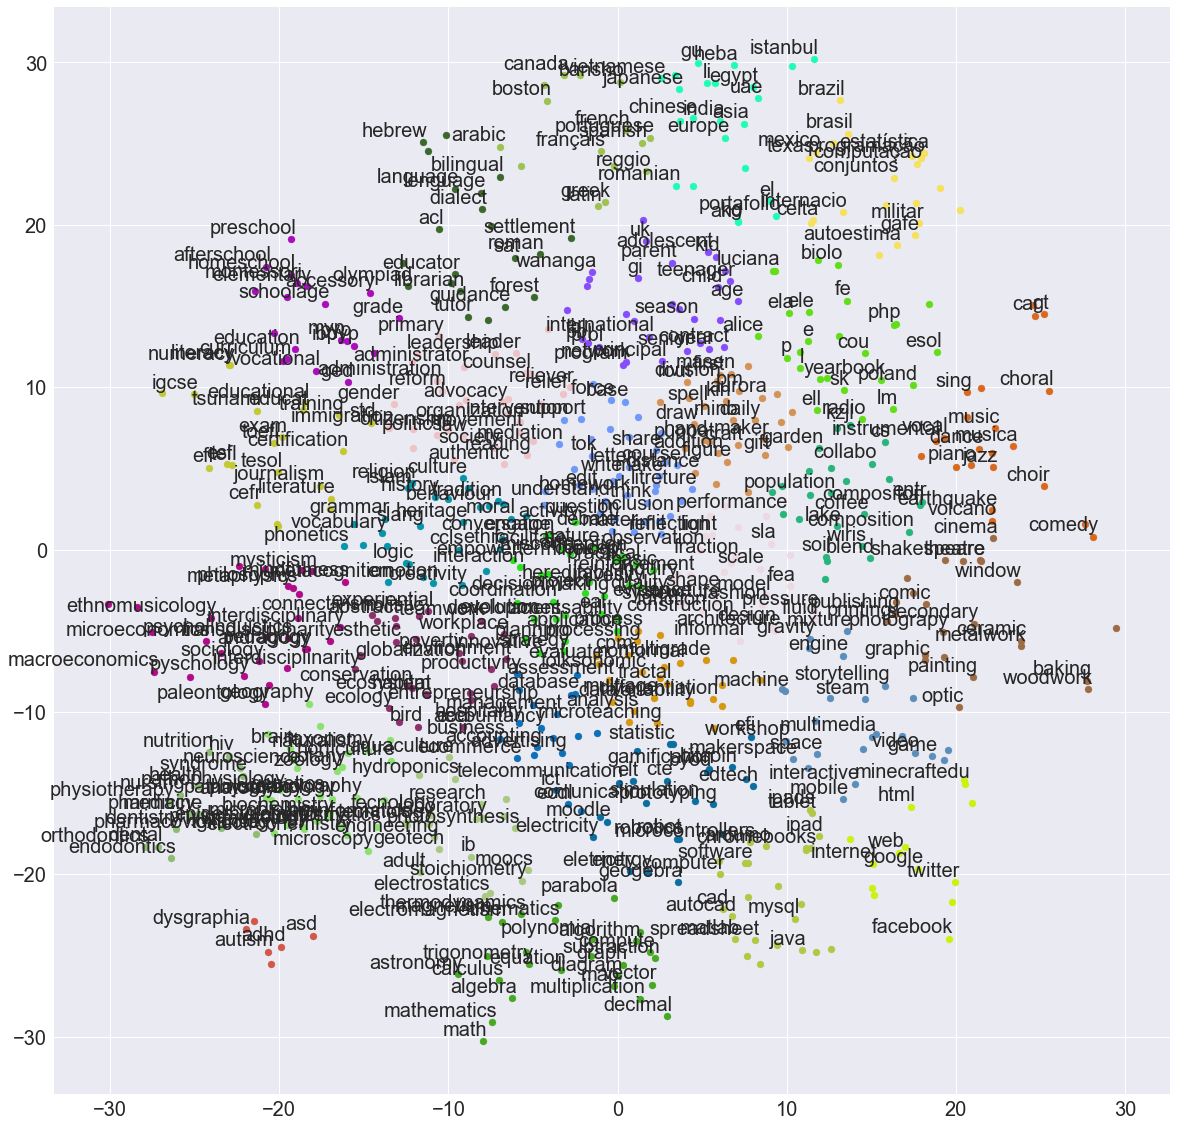

In [35]:
visualisation(K=K, 
              data=tsne_X,
              vocabulary=vocab_fasttext,
              assignment=labels_fasttext,
              colors=cluster_colors,
              plt=plt)

### 1.3.2 Using ConceptNet to find concept for each cluster

In [36]:
"""
    An example of conceptnet.io
"""

test = 'french'

obj = requests.get('http://api.conceptnet.io/c/en/' + test).json()['edges']
for i in range(len(obj)):
    if obj[i]['surfaceText']:# and 'is a type of' in obj[i]['surfaceText']:
        print(obj[i]['surfaceText'])

[[French]] is [[a language]]
[[Français]] is a translation of [[French]]
[[Français]] is a translation of [[French]]
[[language]] is related to [[french]]
[[French]] is used in the region of [[France]]
[[Anglo-French]] is a type of [[French]]
[[Canadian French]] is a type of [[French]]
[[French]] is [[a human language]]
[[French]] is a type of [[Romance]]
[[Langue d oc]] is a type of [[French]]
[[Langue d oil]] is a type of [[French]]
[[Norman-French]] is a type of [[French]]
[[Old French]] is a type of [[French]]
[[Walloon]] is a type of [[French]]
[[French]] is a way to [[cut]]


In [37]:
fasttext_df = find_concept(K=K, df=fasttext_df)

In [38]:
fasttext_df.head()

text processed_text  \
0        area           area   
1  structures      structure   
2        soil           soil   
3          pe             pe   
4         css             cs   

                                            fasttext          x          y  \
0  [-0.17799, -0.26128, 0.31562, 0.12159, -0.3232...  11.388970   3.353632   
1  [-0.037278, -0.031467, 0.036801, 0.42904, -0.1...   5.812960  -3.258491   
2  [-0.25541, -0.17983, -0.12814, 0.14014, -0.362...  12.334512  -0.437158   
3  [-0.086042, 0.13271, 0.0097988, 0.13944, -0.02...  13.077649  13.128714   
4  [0.19479, -0.32558, 0.09338, -0.050811, 0.2083...  15.793037   6.600688   

   cluster                             cluster_center  distance_to_center  \
0       24   [13.327072994554834, 3.0882738680337845]            3.826658   
1        7  [6.7556781372382595, -1.6456643435062186]            3.489926   
2       24   [13.327072994554834, 3.0882738680337845]           13.413852   
3        5    [13.09515917792338, 12.778927084272771]            0.122658   
4       24   [13.327072994554834, 3.0882738680337845]           18.418035   

   representative_cluster                                      related_words  \
0                   False  [district, department, country, extent, room, ...   
1                   False  [arrangement, apodeme, bascule, airdock, blade...   
2                   False  [indurated clay, ground, bole, fuller's earth,...   
3                    True             [hebrew alphabet, pe, อักษรเพ, letter]   
4                   False                                           [cesium]   

  concept  
0   place  
1    body  
2   place  
3  letter  
4   place

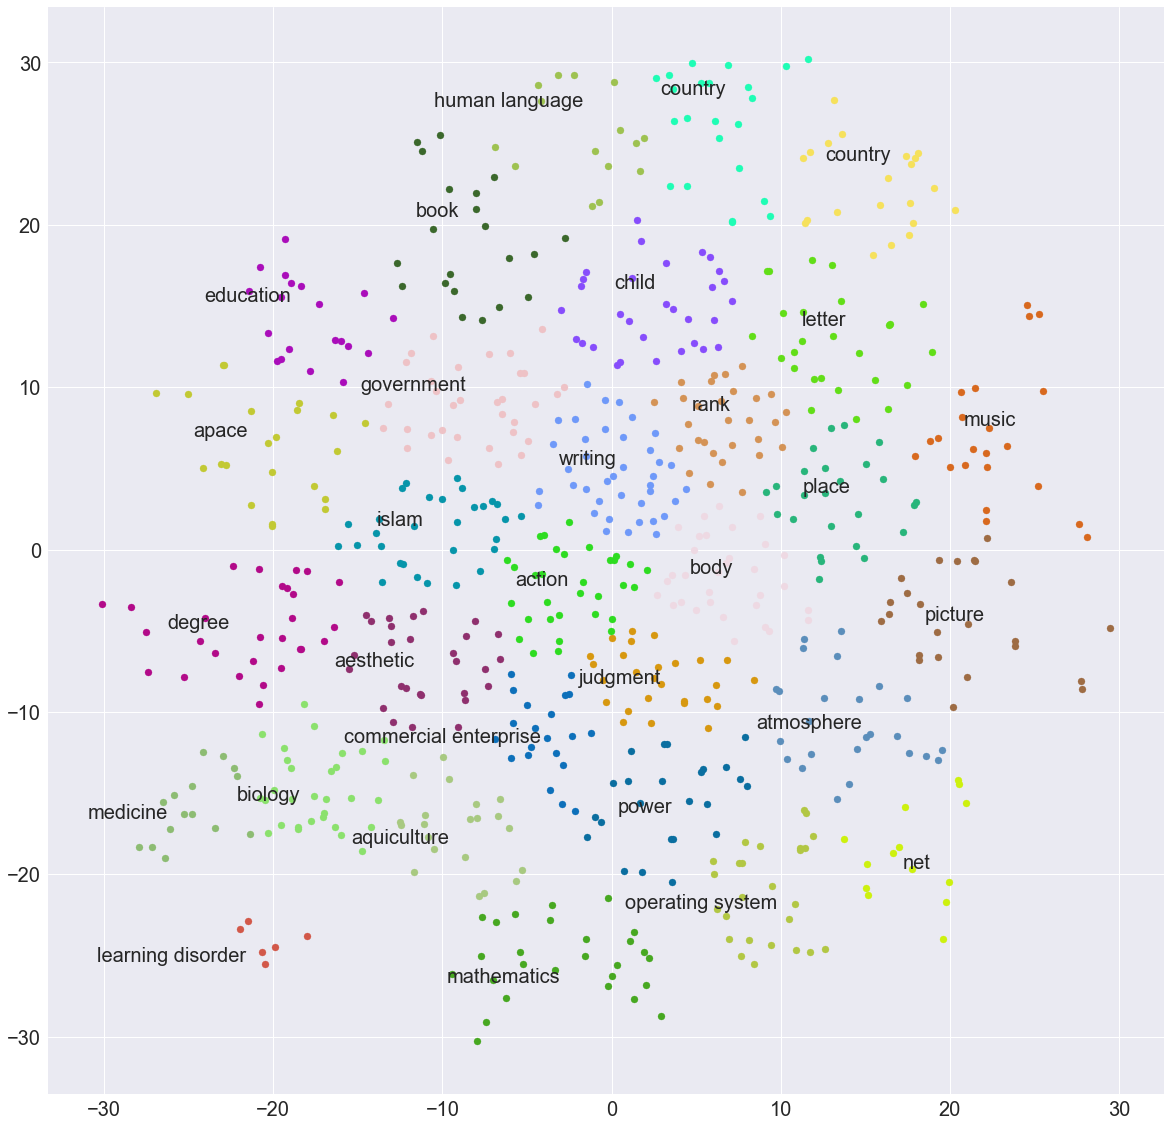

In [39]:
visualisation(K=K, 
              data=tsne_X,
              vocabulary=vocab_fasttext,
              assignment=labels_fasttext,
              colors=cluster_colors,
              plt=plt,
              centralword=True,
              df=fasttext_df)

# 2) Reflection questions dataset
<a id='2'></a>

In [40]:
"""First, open file inqreflection.tsv, 
delete some irrelevant row from line 2400 to 2409"""

ref = pd.read_csv('data/inqreflections.tsv', header = None, sep = '\t', encoding = "ISO-8859-1")
ref = ref.iloc[1:].reset_index().drop('index', 1)
ref.columns = ['week', 'responses']
ref['week'] = ref['week'].astype(dtype=int)
ref.head()

week                                          responses
0     1  {"1": "The WISE simulations allowed the studen...
1     1  {"1": "The most effective aspects in wise acti...
2     1  {"1": "WISE uses predict-observe-explain patte...
3     1  {"1": "It appears that the interactive app all...
4     1  {"1": "Students can make predictions and test ...

In [41]:
ref.tail()

week                                          responses
2422     6  {"1": "In chronic recurrent sialadenitis or ch...
2423     1  {"1": "In chronic recurrent sialadenitis or ch...
2424     5  {"1": "Last year my class created a booklet ca...
2425     1  {"1": "Practical examples using excellent visu...
2426     6  {"1": "As in all classrooms there are many div...

In [42]:
"""
Let print out an entry at index 2423:
As we can see, there are two responses for two different question in this week (1 in this case)
Response is contained in a dictionary

"1":.... , "2".......
        
"""

ref.iloc[2423]['responses']

'{"1": "In chronic recurrent sialadenitis or chronic sclerosing sialadenitis, acute attacks are managed with conservative therapies such as hydration, analgesics (mainly NSAIDs), sialogogues to stimulate salivary secretion, and regular, gentle gland massage.[1] If infection is present, appropriate cultures should be obtained, followed by empirical antibiotic therapy initially,[1] for example amoxicillin/clavulanate or clindamycin which cover oral flora.\\\\r\\\\n\\\\r\\\\nIf there are attacks more than approximately 3 times per year or severe attacks, surgical excision of the affected gland should be considered.[1]", "2": "In chronic recurrent sialadenitis or chronic sclerosing sialadenitis, acute attacks are managed with conservative therapies such as hydration, analgesics (mainly NSAIDs), sialogogues to stimulate salivary secretion, and regular, gentle gland massage.[1] If infection is present, appropriate cultures should be obtained, followed by empirical antibiotic therapy initiall

## 2.1 Processing data
<a id='2.1'></a>

In [43]:
def concatenate_responses(responses):
    """
        Concatenate responses into a list. Excluded QMC's answers
        list[0] = answer for the first question
        list[1] = answer for the second question...
    """
    try:
        responses = list(json.loads(responses.replace('\\\\"','')).values())
    except :
        responses =  ''
        
    return [ x for x in responses if len(x) > 10]


ref['responses'] = ref['responses'].apply(concatenate_responses)
ref.tail()

week                                          responses
2422     6  [In chronic recurrent sialadenitis or chronic ...
2423     1  [In chronic recurrent sialadenitis or chronic ...
2424     5  [Last year my class created a booklet called O...
2425     1  [Practical examples using excellent visuals. C...
2426     6  [As in all classrooms there are many diversiti...

In [46]:
"""
    Remove all reponses non english 
"""

ref['language'] = ref['responses'].apply(detect_language)
ref = ref[ref['language']=='en']
ref = ref.reset_index().drop('index', 1)

"""
    Preprocessing
"""

ref = standardize_responses(ref, "responses")
ref = processing_responses(ref, 'standardized_responses')
ref.tail()

week                                          responses language  \
2375     6  [In chronic recurrent sialadenitis or chronic ...       en   
2376     1  [In chronic recurrent sialadenitis or chronic ...       en   
2377     5  [Last year my class created a booklet called O...       en   
2378     1  [Practical examples using excellent visuals. C...       en   
2379     6  [As in all classrooms there are many diversiti...       en   

                                 standardized_responses  \
2375  [in chronic recurrent sialadenitis or chronic ...   
2376  [in chronic recurrent sialadenitis or chronic ...   
2377  [last year my class created a booklet called o...   
2378  [practical examples using excellent visuals. c...   
2379  [as in all classrooms there are many diversiti...   

                                    processed_responses  
2375  [chronic recurrent sialadenitis chronic sclero...  
2376  [chronic recurrent sialadenitis chronic sclero...  
2377  [last year class create booklet call solar sys...  
2378  [practical example use excellent visuals chall...  
2379  [classroom many diversity different viewpoint ...

In [47]:
ref['nb_responses'] = ref['processed_responses'].apply(lambda x : len(x))

In [48]:
"Original responses, for instance: list[0] = response for question number 1 and so on"

ref.iloc[14]['responses']

['I liked that the students could move at their own pace without having to bring the whole class back together. Students are being assessed as they work so a teacher would not have to stop the learning process to take a grade. The visuals also appeared helpful and the interaction with the visuals appeared meaningful. ',
 "Jennifer was able to monitor the student's progress and engage in conversation with them about the activity instead of leading the instruction. "]

In [49]:
"Standardized responses"

ref.iloc[14]['standardized_responses']

['i liked that the students could move at their own pace without having to bring the whole class back together. students are being assessed as they work so a teacher would not have to stop the learning process to take a grade. the visuals also appeared helpful and the interaction with the visuals appeared meaningful. ',
 "jennifer was able to monitor the student's progress and engage in conversation with them about the activity instead of leading the instruction. "]

In [50]:
"Processed responses"

ref.iloc[14]['processed_responses']

['like student move pace bring whole class back together student assess work teacher stop learning process take grade visuals also appear helpful interaction visuals appear meaningful',
 'jennifer able monitor student progress engage conversation activity instead lead instruction']

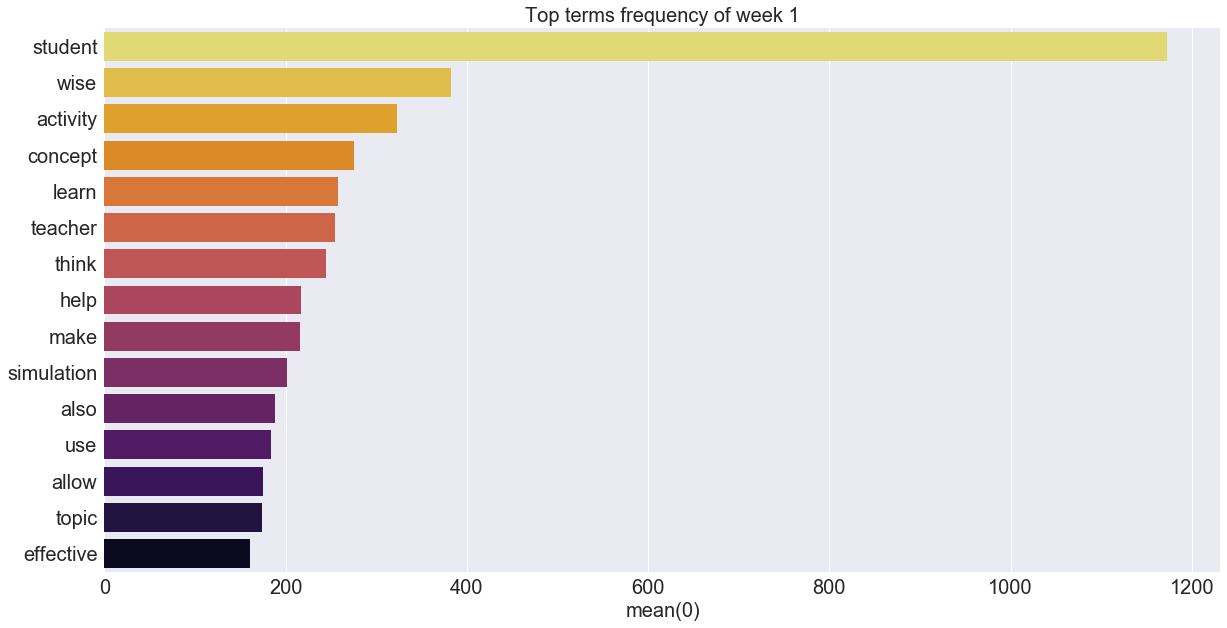

In [51]:
plot_frequency_week(df = ref, week = 1, questionNb = 1, plt = plt)

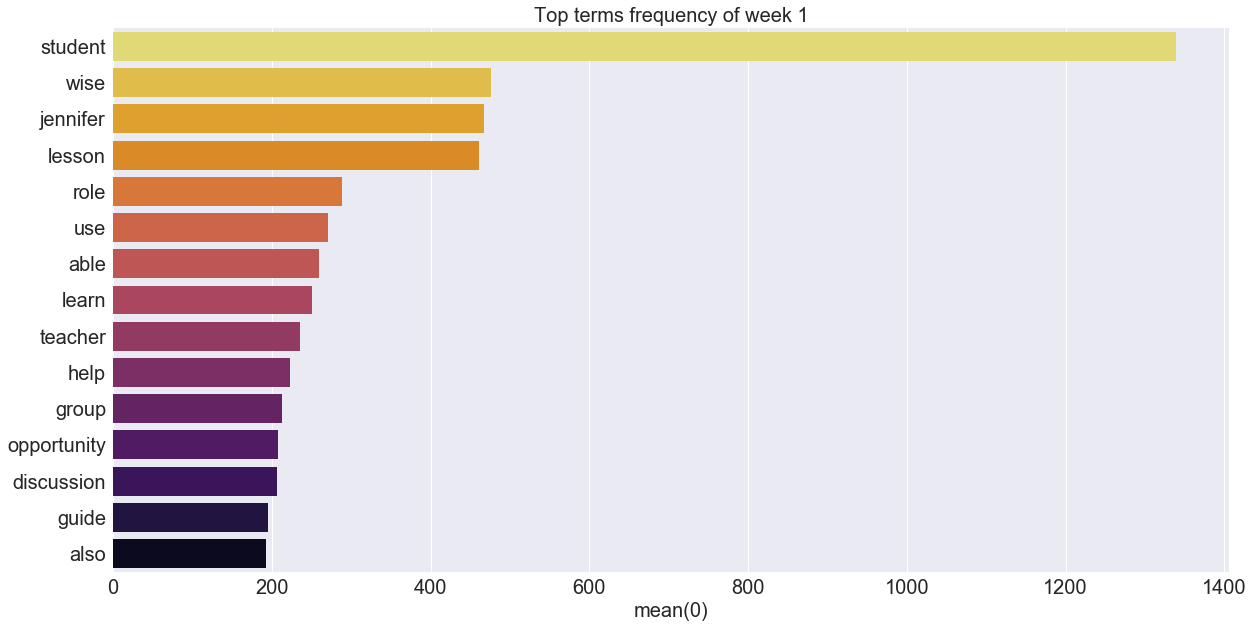

In [52]:
plot_frequency_week(df = ref, week = 1, questionNb = 2, plt = plt)

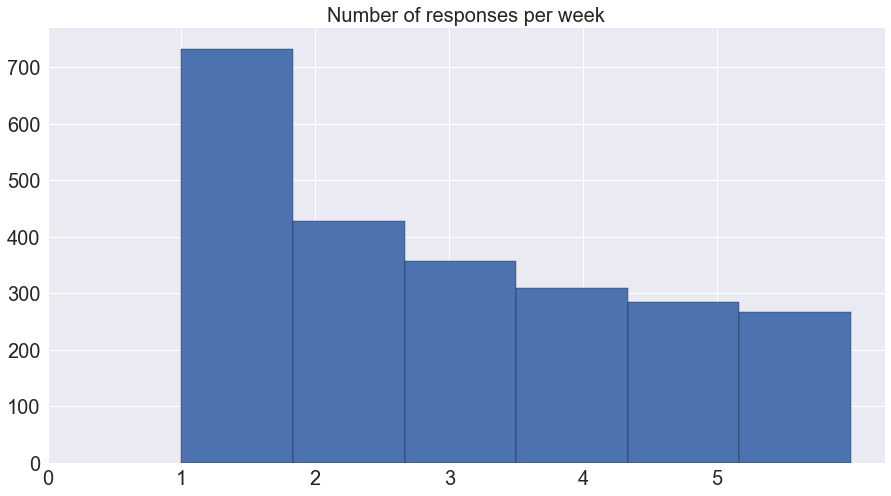

In [53]:
plot_distribution(plt, ref['week'], title="Number of responses per week")

## 2.2) Perform LDA and NMF

<a id='2.2'></a>

In [54]:
TOPICS = 8
N = 5 #retrieve top 10 responses that contribute to each topic

Welcome to LDA algorithm.
Begin find topics for all answers of question number 1 of week 1
Shape of tfidf matrix: (733, 2040)
Topic words distribution shape: (8, 2040)


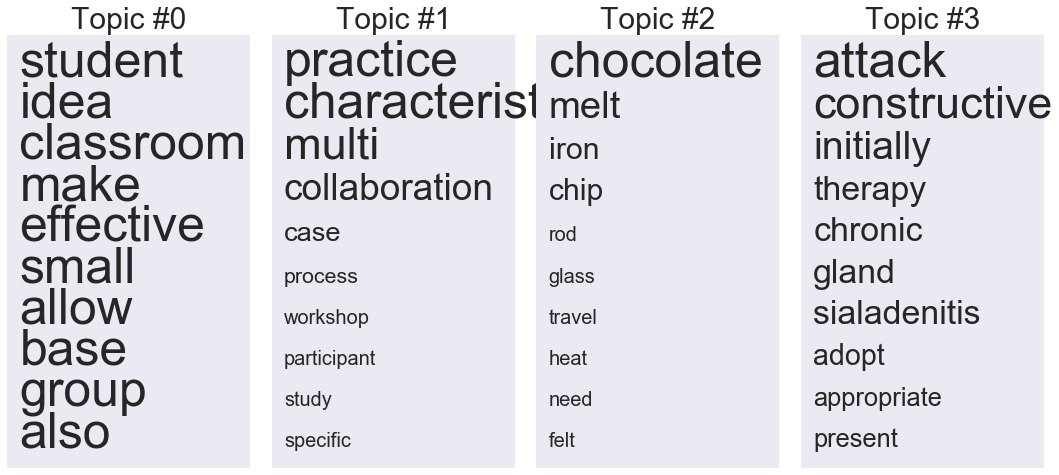

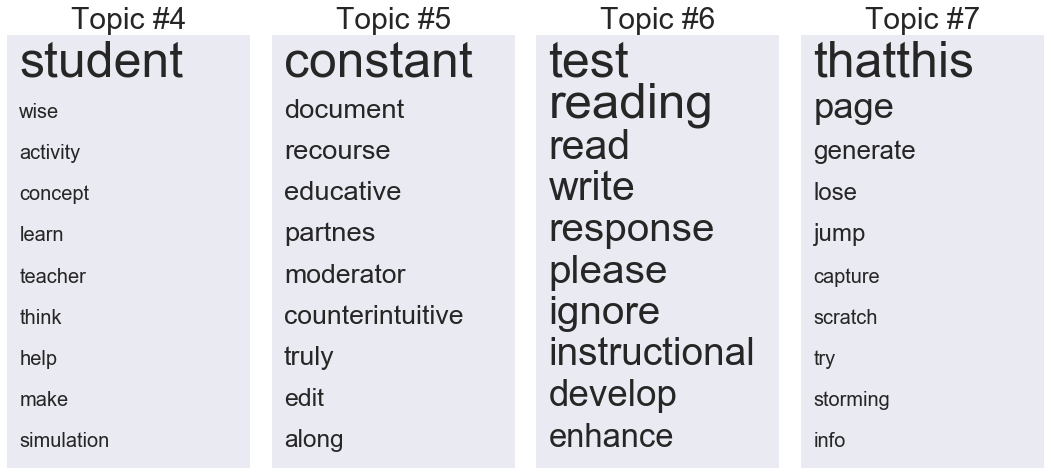

In [55]:
"LDA"

df_lda, sentsTopic_lda, topicsSent_lda = LDA(df = ref, 
                                             week = 1, 
                                             questionNb = 1, 
                                             nbTopic = TOPICS, 
                                             n = N,
                                             plt=plt)

Welcome to NMF algorithm.
Begin find topics for all answers of question number 1 of week 1
Shape of tfidf matrix: (733, 228)
Topic words distribution shape: (8, 228)


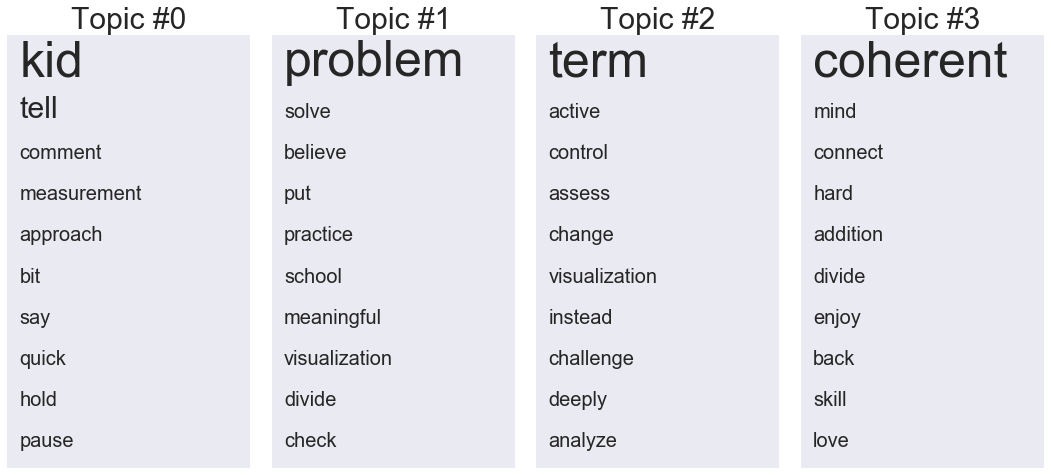

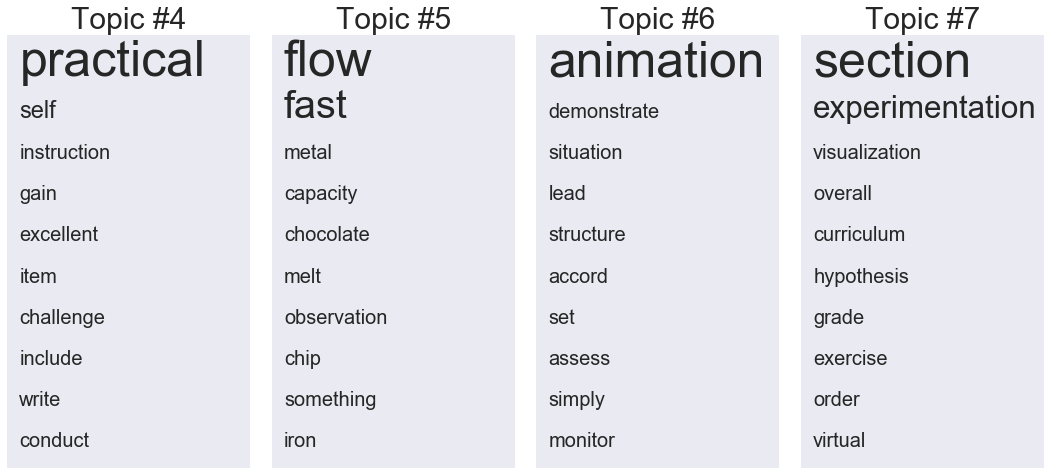

In [56]:
"Non Negative Matrix Factorization"

df_nmf ,sentsTopic_nmf, topicsSent_nmf = nmf(df=ref, 
                                             week=1, 
                                             questionNb = 1, 
                                             nbTopic=TOPICS, 
                                             n=N,
                                             plt=plt)

In [58]:
"""
    Top N responses with the highest similarity with topic 7
"""

print_top_responses_for_topic(sentsTopic_lda, 7, N)

Top 5 responses that contribute for Topic #7
***************
***************
***************
['that they have a page by page guideline of what to do. lots of times my students try jumping ahead and they lose out on the scaffolding. ', 'she was there to answer questions  and ensure that students were progressing appropriately. if she saw common misconceptions or ideas among groups  then it was something she could address to the class. she also led class discussions during pauses of the wise activity.']
--------------------------------------------------
['this and that this and thatthis and thatthis and thatthis and thatthis and thatthis and that', 'that and thisthis and thatthis and thatthis and thatthis and thatthis and thatthis and thatthis and thatthis and that']
--------------------------------------------------
['tailoring lesson plans to suite students. anonymous answer reviews   removes or reduces anxiety and stress for the weaker students which helps to prevent them from losing 

In [59]:
"""
    Find which topics have the most contribution for a specific response
"""

for responseID in range (10):
    print_top_topics_for_response(topicsSent_lda, responseID, N)

Response 0: 0.98*Topic4 + 0.00*Topic2 + 0.00*Topic3 + 0.00*Topic0 + 0.00*Topic5
Response 1: 0.97*Topic4 + 0.00*Topic1 + 0.00*Topic6 + 0.00*Topic0 + 0.00*Topic5
Response 2: 0.92*Topic4 + 0.01*Topic7 + 0.01*Topic0 + 0.01*Topic5 + 0.01*Topic6
Response 3: 0.81*Topic4 + 0.14*Topic3 + 0.00*Topic1 + 0.00*Topic0 + 0.00*Topic5
Response 4: 0.89*Topic4 + 0.01*Topic6 + 0.01*Topic0 + 0.01*Topic5 + 0.01*Topic7
Response 5: 0.99*Topic4 + 0.00*Topic7 + 0.00*Topic3 + 0.00*Topic1 + 0.00*Topic2
Response 6: 0.92*Topic4 + 0.01*Topic3 + 0.01*Topic2 + 0.01*Topic0 + 0.01*Topic5
Response 7: 0.95*Topic4 + 0.00*Topic7 + 0.00*Topic2 + 0.00*Topic0 + 0.00*Topic5
Response 8: 0.98*Topic4 + 0.00*Topic2 + 0.00*Topic7 + 0.00*Topic1 + 0.00*Topic0
Response 9: 0.95*Topic4 + 0.00*Topic2 + 0.00*Topic3 + 0.00*Topic0 + 0.00*Topic5


## 2.3) Fasttext + Ontology + LDA
<a id='2.3'></a>

* Combine Fasttext, Ontology and LDA

In [60]:
ref = extracting_onto(ref, 'standardized_responses', 'nouns_verbs')
ref.head()

week                                          responses language  \
0     1  [The WISE simulations allowed the students to ...       en   
1     1  [The most effective aspects in wise activity w...       en   
2     1  [WISE uses predict-observe-explain patterns wi...       en   
3     1  [It appears that the interactive app allowed t...       en   
4     1  [Students can make predictions and test them. ...       en   

                              standardized_responses  \
0  [the wise simulations allowed the students to ...   
1  [the most effective aspects in wise activity w...   
2  [wise uses predict observe explain patterns wi...   
3  [it appears that the interactive app allowed t...   
4  [students can make predictions and test them. ...   

                                 processed_responses  nb_responses  \
0  [wise simulation allow student conceptualize a...             2   
1  [effective aspect wise activity create spirit ...             2   
2  [wise use predict observe explain pattern prom...             2   
3  [appear interactive app allow visualize scienc...             2   
4  [student make prediction test work small group...             2   

                                         nouns_verbs  
0  [wise simulation allow student conceptualize i...  
1  [aspect wise activity create spirit team encou...  
2  [wise use predict observe explain pattern prom...  
3  [appear app allow visualize science reflect go...  
4  [student make prediction test work group  , se...

In [61]:
"Count number of nouns and verbs before replacing"

ontology_features = count(ref, 'nouns_verbs')

There are 5277 nouns and verbs in the dataset


In [62]:
"Mapping noun/verb to a vector using Fasttext/Word2Vec"

ontology2fas = []
ontology2vec = []
for ontology in ontology_features:
    if ontology in fasttext:
        ontology2fas.append(fasttext[ontology])
    else:
        ontology2fas.append(np.array([0.0]*300))
        
for ontology in ontology_features:
    if ontology in word2vec:
        ontology2vec.append(word2vec[ontology])
    else:
        ontology2vec.append(np.array([0.0]*300))
        
        
analysis_noun_df = pd.DataFrame({
                        'ontology_features' : ontology_features,
                        'fasttext' : ontology2fas,
                        'word2vec' : ontology2vec
                    })
analysis_noun_df.head()

fasttext ontology_features  \
0  [-0.46529, -0.0041742, -0.29827, 0.5952, -0.36...              aand   
1  [-0.0232, -0.63172, 0.0064282, -0.28996, -0.07...                ab   
2  [0.037252, -0.016389, -0.62663, -0.010042, -0....          abilites   
3  [-0.098041, 0.1796, -0.57259, 0.073026, -0.084...           ability   
4  [-0.030951, -0.036293, -0.26573, 0.34186, -0.3...          abilties   

                                            word2vec  
0  [0.084472656, -0.010498047, -0.104003906, 0.20...  
1  [0.064941406, 0.24121094, 0.05444336, 0.191406...  
2  [0.10498047, 0.111816406, 0.075683594, -0.0134...  
3  [0.23828125, 0.125, -0.056640625, 0.050048828,...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [63]:
"Example of some useful functions in Fasttext "

a = fasttext['carpentry']
b = fasttext['woodcutting']
cosine_similarity(a, b)

/Users/Cescnghia/Applications/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Cescnghia/Applications/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[0.6145797]], dtype=float32)

In [64]:
"Most similar to the word `carpentry` according to Fasttext"

#fasttext.most_similar('carpentry')

'Most similar to the word `carpentry` according to Fasttext'

In [65]:
"Compute the cosin similarity between noun"

X = [x.tolist() for x in analysis_noun_df['fasttext']]
distances_matrix = cosine_similarity(X, X)

"Then find the most similar"

features = np.array(ontology_features)
for idx, noun in enumerate(features):
    if (idx < 50 and idx > 40): # Print a few terms
        min_distances = distances_matrix[idx,:].argsort()[::-1][1:5]
        print('Top closest words with `{n}`'.format(n=noun))
        print(features[min_distances])
        print(distances_matrix[idx,:][min_distances])
        print('---------------------')

Top closest words with `accumulate`
['amass' 'collect' 'absorb' 'amount']
[0.5772852  0.55280498 0.54414115 0.54024794]
---------------------
Top closest words with `accuracy`
['accurate' 'precision' 'reliability' 'precise']
[0.7257426  0.68427598 0.67939313 0.61525144]
---------------------
Top closest words with `accurate`
['precise' 'accuracy' 'correct' 'reliably']
[0.74164024 0.7257426  0.67904365 0.63412565]
---------------------
Top closest words with `accustom`
['custom' 'instruct' 'endure' 'mindful']
[0.54153154 0.51714454 0.50653125 0.50211579]
---------------------
Top closest words with `ace`
['pilot' 'charley' 'card' 'kid']
[0.44535383 0.37461949 0.36595719 0.34975343]
---------------------
Top closest words with `acheive`
['achieve' 'achievment' 'accomplish' 'thats']
[0.63714701 0.62186611 0.56187458 0.55692392]
---------------------
Top closest words with `achieve`
['achieving' 'attain' 'accomplish' 'gain']
[0.80777509 0.77095131 0.72676383 0.64183308]
-------------------

In [66]:
replace = find_top_most_similarity(ontology_features, analysis_noun_df, threshold = .9)

=====> We can replace `achivement` by `achivements`
---------------------
=====> We can replace `achivements` by `achivement`
---------------------
=====> We can replace `adaptation` by `adaption`
---------------------
=====> We can replace `adaption` by `adaptation`
---------------------
=====> We can replace `adviser` by `advisor`
---------------------
=====> We can replace `advisor` by `adviser`
---------------------
=====> We can replace `allows` by `enables`
---------------------
=====> We can replace `angeles` by `los`
---------------------
=====> We can replace `anybody` by `anyone`
---------------------
=====> We can replace `anyone` by `anybody`
---------------------
=====> We can replace `assigment` by `assigments`
---------------------
=====> We can replace `assigments` by `assigment`
---------------------
=====> We can replace `behavior` by `behaviour`
---------------------
=====> We can replace `behaviour` by `behavior`
---------------------
=====> We can replace `colabora

In [67]:
"Let see now, after the replacement, how many nouns do we have"

_ = count(ref, 'nouns_verbs',replacement=True, replace=replace)

There are 5261 nouns and verbs in the dataset


Welcome to LDA algorithm.
Begin find topics for all answers of question number 1 of week 1
Shape of tfidf matrix: (733, 2037)
Topic words distribution shape: (8, 2037)


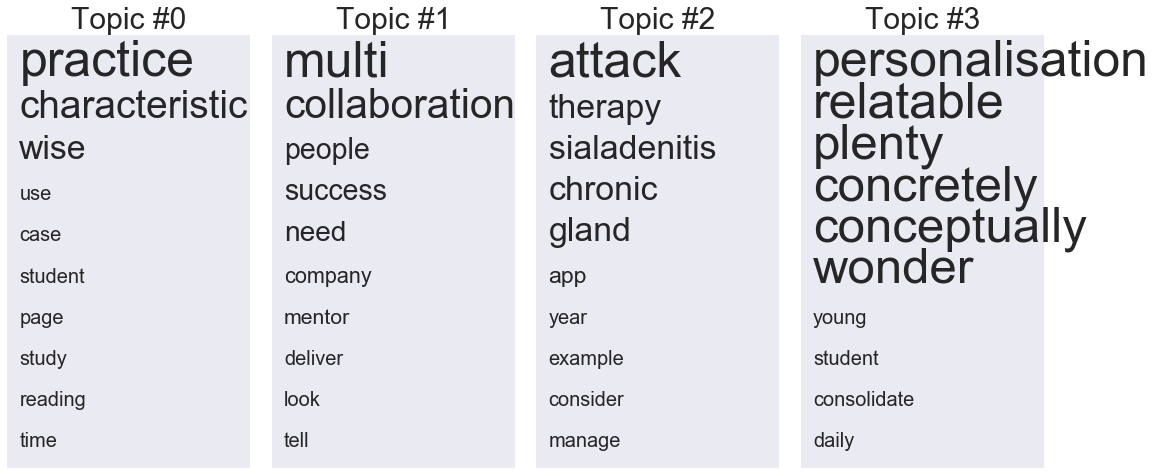

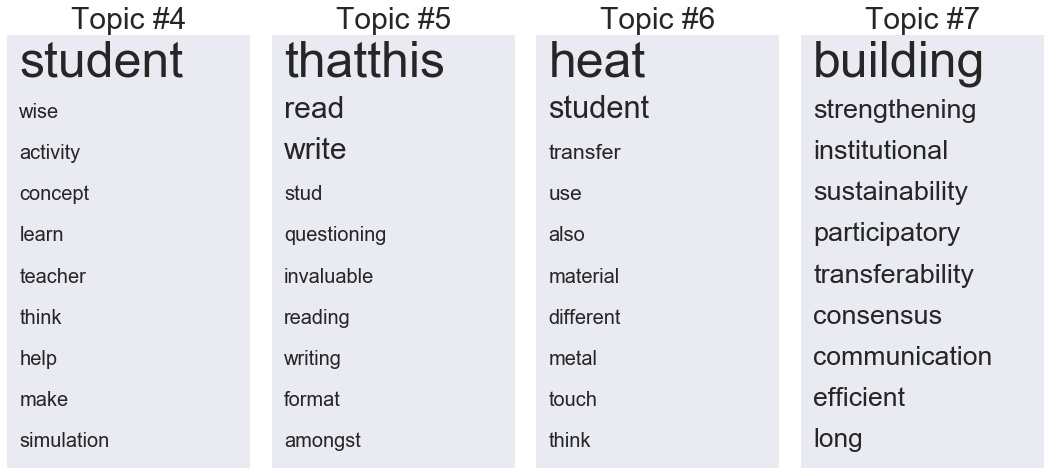

In [68]:
_, sentsTopic_lda_onto, topicsSent_lda_onto = LDA(df = ref, 
                                                       week = 1,
                                                       questionNb = 1, 
                                                       nbTopic = TOPICS, 
                                                       n = N,
                                                       plt=plt,
                                                       replacement=True,
                                                       replace=replace)

## 2.4) Latent semantic indexing

<a id='2.4'></a>

### 2.4.1) Students' responses - concept space similarity

In [69]:
df_resp_1 = search(df=ref, 
                   week=1, 
                   questionNb=1, 
                   latentSpace=100, 
                   yourConcept='hot chocolate',
                   n=N)

There are 733 responses in 2040 significant terms


NameError: name 'processing_response' is not defined

In [ ]:
df_resp_1.iloc[414]['responses']

In [ ]:
df_resp_1.iloc[170]['responses']

In [ ]:
df_resp_2 = search(df=ref, 
                   week=1, 
                   questionNb=1, 
                   latentSpace=100, 
                   yourConcept='facebook',
                   n=N)

### 2.4.2) Students' responses similarity

In [ ]:
scores, new_df, U, V, vocab = compute_response_similarity(df=ref, 
                                                          week=1, 
                                                          questionNb=1, 
                                                          latentSpace=100, 
                                                          n = N)

In [ ]:
new_df.iloc[101]['responses']

In [ ]:
new_df.iloc[210]['responses']

In [ ]:
new_df.iloc[534]['responses']

In [ ]:
features_truc = np.array(vocab)
for i in range(100):
    dist = V[:,i]
    max_ = dist.argsort()[::-1][1:10]
    print('Top contributed words for latent `{n}`'.format(n=i))
    print(features_truc[max_])
    print(dist[max_])
    print('---------------------')

In [ ]:
"Then find the most similar"

features_truc = np.array(vocab)
for idx, noun in enumerate(features_truc):
    if (idx < 50): # Print only the first 50 nouns 
        min_distances = distances_truc[idx,:].argsort()[::-1][1:5]
        print('Top closest words with `{n}`'.format(n=noun))
        print(features_truc[min_distances])
        print(distances_truc[idx,:][min_distances])
        print('---------------------')

# 3) Hypothesis dataset
<a id='3'></a>

In [ ]:
hyp = pd.read_csv('data/hypothesis.tsv', header = None, sep = '\t', encoding = "ISO-8859-1")
hyp.columns = ['original', 'annotated', 'source']
hyp.dropna(inplace=True)
hyp = hyp.reset_index().drop('index', 1)
hyp.head(7)